## Questions to answer about metabolite data
1. How many FAs and lipids are hiding in the data? 
    - Go after them by RT and m/z, 
    - Also check for P in the Formula
    - then double check their overlap with an identical mass & class lipid from the lipidomics data. 
    - Expect to see high pearson correlation 
2. Gap fill status numbers
3. What in-source fragments exist in the data? 
    - Check via special distance metric `dist = (RT_diff) + (1 - pearson_corr)`

In [241]:
import csv
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage

from collections import OrderedDict, defaultdict

## Parse Compound Discoverer output 

In [253]:
cd_path = '../data/CD33/Nilerat_metabs_20220516_compounds.csv'
cs_path = '../data/CD33/Nilerat_metabs_20220516_chemspider.csv'

cd_all = pd.read_csv(cd_path)#.to_csv('../data/CD33/CD33_nilerat_metabs.csv')

cs = []
with open(cs_path, encoding='utf-8-sig') as f:
    r = csv.reader(f)
    for line in r:
        cs.append(line)
        
headers = cs[0]
cs_headers = cs[2]

ion_type_index = headers.index('Reference Ion')  # Get index of Reference Ion (e.g. [M+H]+1) in headers
cs_name_index = cs_headers.index('Name')         # Get index of chemspider name

df = []

for i, line in enumerate(cs[1:], start=1):
    cs_names = []
    if '[' in line[ion_type_index]:  # New Compound
        compound_line_index = i
        cs_line_index = compound_line_index + 2
#         print(cs[0])
        try:
            while cs[cs_line_index][1] == 'FALSE':
                cs_names.append(cs[cs_line_index][cs_name_index])
                cs_line_index += 1
        except IndexError:
            pass
        result = {header: entry for header, entry in zip(headers, cs[compound_line_index])}
        result['cs_ids'] = cs_names
        df.append(result)
    else:
        continue    
cd = pd.DataFrame(df)
cd

,Name,Formula,Annot. Source: Predicted Compositions,Annot. Source: mzCloud Search,Annot. Source: mzVault Search,Annot. Source: ChemSpider Search,Reference Ion,Annot. DeltaMass [ppm],m/z,RT [min],...,Group Area: 20210831_KAO_HILIC_T1101M_20210413_10wk_RBG,Group Area: 20210831_KAO_HILIC_T1102M_20210327_8wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210402_9wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210406_9wk_RBG,Group Area: 20210831_KAO_HILIC_T1102M_20210410_10wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210413_10wk_RBG,# Adducts,mzCloud Library Match: Autoprocessed,mzCloud Library Match: Reference,cs_ids
0,Wow! 1082 1076 Piracetam/Ectoine,C6 H10 N2 O2,Full match,No results,No results,Full match,[M-H]-1,-7.31,141.06591,2.353,...,177071.8902,120770.0073,98626.19929,365495.1931,287281.4316,118843.1106,1,No matches found,No matches found,"[Piracetam, Ectoine, Ectoine]"
1,Very close mz and RT to Tyrosine but actually ...,C9 H11 N O3,No match,Not the top hit,No results,No results,[M-H]-1,-44.8,180.0585,11.539,...,4222484.68,1808165.359,1378909.756,4309743.921,1772156.809,3651613.042,1,Single match found,Multiple matches found,[]
2,Urocanic acid,C6 H6 N2 O2,Full match,Full match,Full match,Partial match,[M+H]+1,-2.71,139.05028,11.365,...,7631763.822,13295139.15,7605684.75,12956306.41,18341687.29,1923477.649,2,Single match found,Multiple matches found,"[4-Nitroaniline, Urocanic acid, 2-Aminonicotin..."
3,Uridine,C9 H12 N2 O6,Full match,Full match,Full match,Full match,[M-H]-1,-3.02,243.06152,7.513,...,15261253.94,33999807.19,26254317.42,14627592.23,27136967.06,15186827.1,1,No matches found,Single match found,"[1-Pentofuranosyl-2,4(1H,3H)-pyrimidinedione, ..."
4,Uric acid,C5 H4 N4 O3,Full match,Full match,Full match,Full match,[M-H]-1,-5.85,167.02007,12.732,...,102211252.7,594144.1235,30472182.37,231940310,93046706.78,60152726.06,2,No matches found,Single match found,"[Uric Acid, 5,7-Dihydro-1H-purine-2,6,8(3H)-tr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,,C12 H16,Full match,Invalid mass,No results,Full match,[M+H]+1,0.34,161.13253,1.403,...,1188722.533,1682776.688,1050713.661,959057.2882,755627.7434,697310.5927,1,Multiple matches found,Single match found,"[p-Isopropyl-α-methylstyrene, 1-Isopropenyl-3-..."
626,,C12 H10 N2 O S,Not the top hit,No results,No results,Full match,[M-H]-1,-3.14,229.04342,8.657,...,606584.4324,2730115.612,1157038.902,1740276.857,2197807.982,1282504.727,2,No matches found,No matches found,[6-Methoxy-3-(2-thiazolyl)-1H-indole]
627,,C24 H33 F O6,No match,Full match,No results,Full match,[M+H]+1,5.7,437.23588,1.775,...,820359.8176,728563.1602,738303.8355,287274.218,830319.8294,144476.9027,1,Multiple matches found,Single match found,"[fludroxycortide, 11?,16?,17?,21-tetrahydroxy-..."
628,,C12 H17 N4 O2 P S,Full match,Invalid mass,No results,No match,[M-H]-1,-6.28,311.07175,9.539,...,48028.90619,1040345.206,400012.7927,159755.2927,381254.3632,98551.57161,1,Single match found,No matches found,"[diclocymet, Epithienamycin B, carbapenem MM22..."


In [254]:
[c for c in cd.columns]

['Name',
 'Formula',
 'Annot. Source: Predicted Compositions',
 'Annot. Source: mzCloud Search',
 'Annot. Source: mzVault Search',
 'Annot. Source: ChemSpider Search',
 'Reference Ion',
 'Annot. DeltaMass [ppm]',
 'm/z',
 'RT [min]',
 'Tags',
 'Checked',
 'MS2',
 'Area (Max.)',
 'mzVault Library Match: Bamba lab 598 polar metabolites stepped NCE 10 30 45',
 'mzVault Library Match: Combined_79246Pos_36055Neg_MassBank_20200213',
 'mzVault Library Match: Customer_Library_ESI_WatersAmideHILIC_HCD_20200821_YYZ',
 'mzVault Library Match: Fiehn HILIC_3061 entries_20200213',
 'mzVault Library Match: KI-GIAR_zic-HILIC_Pos_v0.90_814 entries_20200213',
 '# mzVault Results',
 'mzVault Best Match',
 'mzCloud Best Match',
 '# ChemSpider Results',
 'mzCloud Best Match Confidence',
 '# mzCloud Results',
 'Peak Rating: 20210831_KAO_HILIC_ACN_20210831232610.raw (F1)',
 'Peak Rating: 20210831_KAO_HILIC_extraction_blank_1.raw (F2)',
 'Peak Rating: 20210831_KAO_HILIC_extraction_blank_1_20210901004002.raw (

# Data wrangling to make new columns with metadata

In [261]:
cd['polarity'] = cd['Reference Ion'].str[-2]
cd['Checked'] = cd['Checked'].map({'TRUE': True, 'FALSE': False})
areas = cd_all.filter(regex='Group').columns
cd[areas] = np.log2(cd[areas].astype('float'))
cd['max_area'] = cd[areas].max(axis=1)
cd['mean'] = cd[areas].mean(axis=1)
cd['is_id'] = (cd['Name'] != '') & (cd['Checked'])
cd['polarity'] = cd['Reference Ion'].apply(lambda x: ('+' if x[-2] == '+' else '-'))
cd[['RT [min]', 'm/z']] = cd[['RT [min]', 'm/z']].astype('float')

def parse_tags(text):
    output = [
        ('mzCloudID' in text), 
        ('mzVaultID' in text), 
        ('ChemSpiderID' in text),
        ('Lipid' in text), 
        ('11.5' in text),
    ]
    return output
cd['mzcloud'], cd['mzvault'], cd['chemspider'], cd['is_lipid'], cd['11.5'] = zip(*cd['Tags'].map(parse_tags))

cd['confident_id'] = ( (cd['mzvault'] | cd['mzcloud']) & \
                      (~cd['is_lipid']) & \
                      (cd['Checked']) & \
                      (~cd['Name'].str.contains('drop this duplicate'))
                    )

def make_unique_name(name, confident_id, rt, mz):
    if name == '' or not confident_id:
        name = 'unknown_'
    else:
        name += '_'
    return name + str(round(rt, 3)) + '_' + str(mz)
cd['uniqueid'] = cd.apply(lambda x: make_unique_name(x['Name'], x['confident_id'], x['RT [min]'], x['m/z']), axis=1)
cd['uniqueid']

0       unknown_2.353_141.06591
1       unknown_11.539_180.0585
2      unknown_11.365_139.05028
3       unknown_7.513_243.06152
4      unknown_12.732_167.02007
                 ...           
625     unknown_1.403_161.13253
626     unknown_8.657_229.04342
627     unknown_1.775_437.23588
628     unknown_9.539_311.07175
629     unknown_6.736_143.11796
Name: uniqueid, Length: 630, dtype: object

# Perform clustering of features based on:
## 1. feature quant correlation and 
## 2. feature RT difference 

In [262]:
cd_subset = cd.loc[~cd['is_lipid']]

# calculate absolute value of RT deviation between each feature
rt_dist = squareform(pdist(cd_subset['RT [min]'].values.reshape(-1, 1), metric='cityblock'))

# Calculate correlation between features
corr = cd_subset[areas].T.corr('spearman')
# Convert correlation into a valid distance metric
corr_dist = (1 - corr)
# multiply correlation distance by a factor to upweight or downweight its importance
#    small multiplier = more important 
corr_dist = 1 * corr_dist
# Sum pearson and RT deviations to get custom distance metric
rt_corr_dist = corr_dist + rt_dist
rt_corr_dist.index = cd_subset['uniqueid']
rt_corr_dist.columns = cd_subset['uniqueid']
display(rt_corr_dist)
rt_corr_linkage = linkage(squareform(rt_corr_dist), method='complete', metric='cityblock')

# We don't care about hierarchical clustering of all feature groups, we only care about
#      the most highly correlated clusters to find in-source frags. 
#      Therefore, use flat clustering to derive clusters that are under the minimum distance 't'
ifclusts = fcluster(rt_corr_linkage, t=0.1, criterion='distance')  # ifclusts = In-source Fragment Clusters
cluster_membership = defaultdict(list)
for cluster, metab in zip(ifclusts, cd_subset['uniqueid']):
    cluster_membership[cluster].append(metab)
cluster_membership = dict(cluster_membership)
cluster_membership = sorted(cluster_membership.items(), 
                            key=(lambda item: len(item[1])),
                            reverse=True,)
cluster_membership[0][1]

uniqueid,unknown_2.353_141.06591,unknown_11.539_180.0585,unknown_11.365_139.05028,unknown_7.513_243.06152,unknown_12.732_167.02007,unknown_11.137_180.06563,unknown_9.861_203.0817,unknown_9.139_138.05502,unknown_9.866_188.07065,unknown_12.071_120.06577,...,unknown_6.463_172.11935,unknown_9.502_239.01414,unknown_11.448_413.08344,unknown_7.996_166.08387,unknown_9.469_173.09213,unknown_6.857_188.0708,unknown_1.403_161.13253,unknown_8.657_229.04342,unknown_9.539_311.07175,unknown_6.736_143.11796
uniqueid,,,,,,,,,,,,,,,,,,,,,
unknown_2.353_141.06591,0.000000,9.921649,9.781103,6.268864,11.606841,9.661466,8.516447,7.848517,8.519057,10.691548,...,4.990911,8.195791,9.949071,6.685345,7.948565,5.369852,1.840192,7.118337,8.223955,5.691419
unknown_11.539_180.0585,9.921649,0.000000,1.231849,5.523194,2.132316,0.917088,2.240378,2.746318,2.137573,0.728777,...,6.240323,3.231665,0.165298,4.078927,2.872501,4.965857,11.287987,3.759799,3.250903,6.290135
unknown_11.365_139.05028,9.781103,1.231849,0.000000,4.471672,2.516764,1.138920,2.539176,3.354202,2.585580,1.790468,...,5.493220,2.686006,1.141405,4.555274,2.430315,5.606027,10.830074,3.399303,2.665844,5.405049
unknown_7.513_243.06152,6.268864,5.523194,4.471672,0.000000,6.331587,4.828446,3.615630,3.141143,3.728382,6.025019,...,1.465615,2.342821,5.348337,2.007701,2.637189,2.189648,7.011306,1.666145,2.370262,1.210454
unknown_12.732_167.02007,11.606841,2.132316,2.516764,6.331587,0.000000,2.481691,3.554190,4.402114,3.575030,1.565751,...,7.268555,4.083793,2.199032,5.543447,4.406095,6.730293,12.916997,5.058051,4.000669,6.564269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unknown_6.857_188.0708,5.369852,4.965857,5.606027,2.189648,6.730293,4.759578,3.442733,2.485779,3.336313,5.424947,...,1.595723,4.078676,4.909533,1.500989,3.636396,0.000000,6.465670,2.988386,4.185029,1.504218
unknown_1.403_161.13253,1.840192,11.287987,10.830074,7.011306,12.916997,10.824692,9.789425,8.813466,9.737243,11.834157,...,6.030992,9.297611,11.225272,7.701586,9.078837,6.465670,0.000000,8.458390,9.322385,6.522775
unknown_8.657_229.04342,7.118337,3.759799,3.399303,1.666145,5.058051,3.309675,2.120421,1.581028,2.206055,4.355261,...,2.610227,1.104239,3.575162,1.929964,1.217446,2.988386,8.458390,0.000000,1.221039,2.596465


['unknown_11.539_180.0585',
 'unknown_11.565_179.05517',
 'unknown_11.581_71.01277',
 'unknown_11.561_113.02329',
 'unknown_11.572_401.07464',
 'unknown_11.563_101.02331',
 'unknown_11.558_119.03387',
 'unknown_11.596_143.03391',
 'unknown_11.572_369.10903',
 'unknown_11.576_222.06116',
 'unknown_11.564_239.07651',
 'unknown_11.579_143.03392']

## Where do these hypothetical in-source fragments live? 

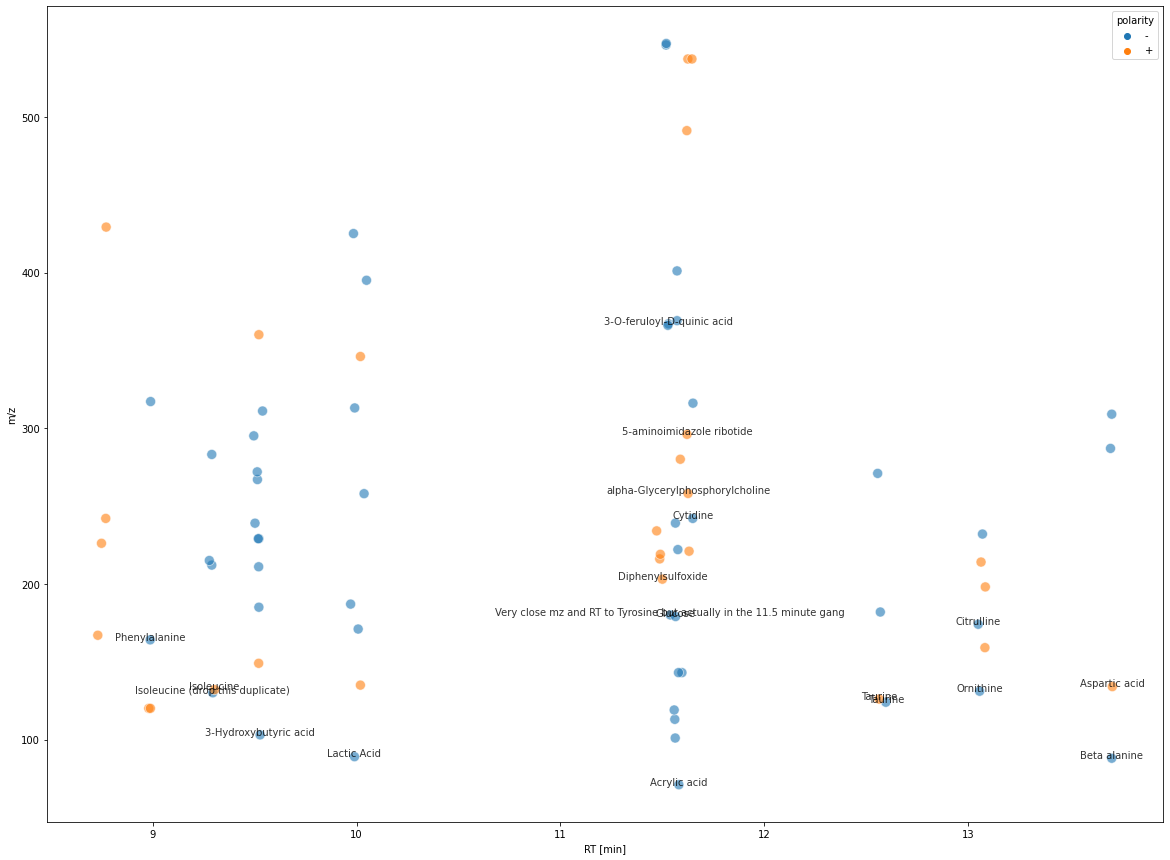

In [269]:
fig, ax = plt.subplots()
# cluster_unique_ids = cluster_membership[0][1]
    
# cluster_unique_ids = [x[1] for x in cluster_membership[:15]]
cluster_unique_ids = [x[1] for x in cluster_membership if len(x[1]) > 3]
cluster_unique_ids = [item for sublist in cluster_unique_ids for item in sublist]  # Flatten the list of lists

subset = cd.loc[cd['uniqueid'].isin(cluster_unique_ids)]
# subset = cd.loc[cd['chemspider']]
sns.scatterplot(
    data=subset,
#     data=cd, style='Checked', markers={True: 'o', False: 'X'},
    y='m/z',
    x='RT [min]',
    hue='polarity',
#     size='is_id', sizes={True: 80, False: 25},
    alpha=0.6,
    s=100,
    ax=ax,
)

for i, row in subset.iterrows():
    plt.annotate(row['Name'], (row['RT [min]'], row['m/z']), 
             horizontalalignment='center', size='medium', color='black', 
             alpha=0.8,
            )

fig.set_size_inches(20, 15)
# plt.xlim(1, 19)
# plt.xlim(8, 14)
# plt.ylim(70, 950)

In [ ]:
fig, ax = plt.subplots()
dg = dendrogram(
    rt_corr_linkage,
    truncate_mode='level', p=12, 
    orientation='left',
    ax=ax,
)
fig.set_size_inches(6, 25)

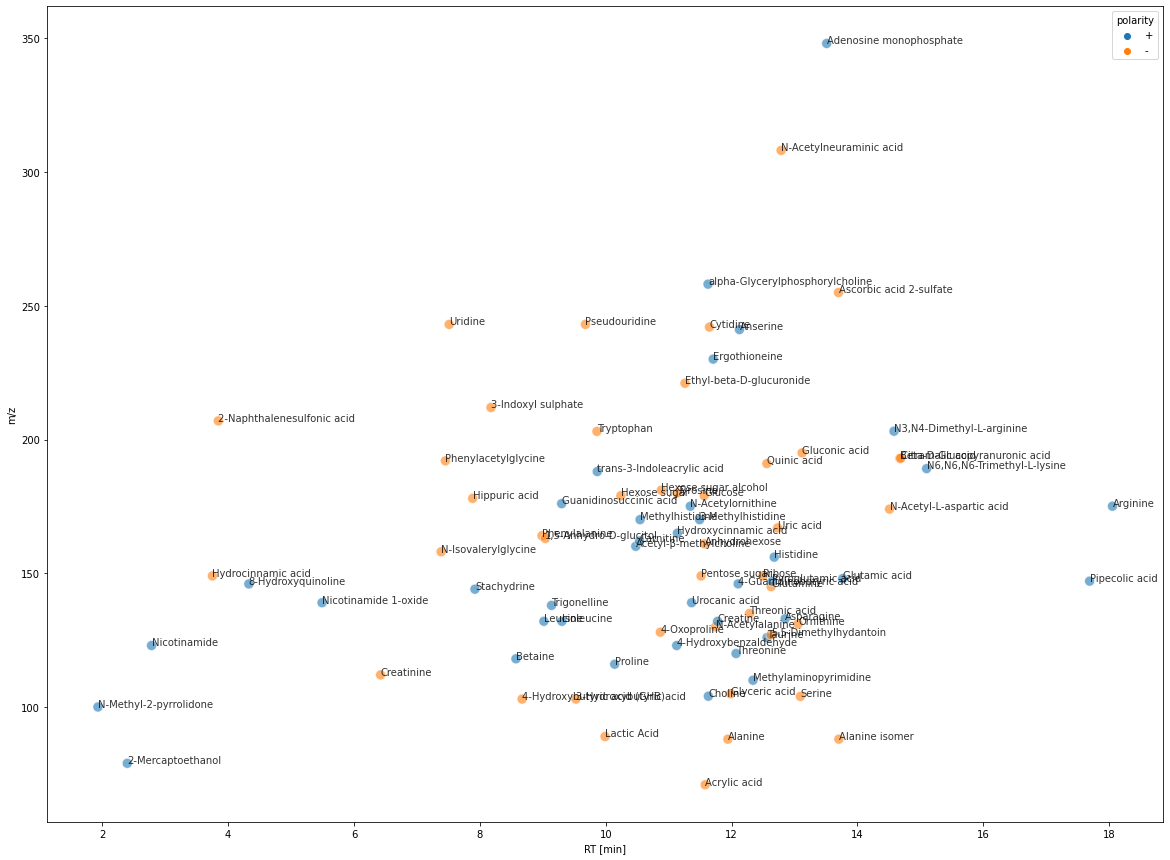

In [464]:
fig, ax = plt.subplots()
subset = cd.loc[cd['confident_id']]
# subset = cd.loc[cd['chemspider']]
sns.scatterplot(
    data=subset,
#     data=cd, style='Checked', markers={True: 'o', False: 'X'},
    y='m/z',
    x='RT [min]',
    hue='polarity',
#     size='is_id', sizes={True: 80, False: 25},
    alpha=0.6,
    s=100,
    ax=ax,
)

for i, row in subset.iterrows():
    plt.annotate(row['Name'], (row['RT [min]'], row['m/z']), 
             horizontalalignment='left', size='medium', color='black', 
             alpha=0.8,
            )

fig.set_size_inches(20, 15)
# plt.xlim(0, 5)
# plt.ylim(70, 950)

In [516]:
test = {1: [1,2,3], 2: [1,2]}
{key: value for key, value in test.items() if len(value) > 2}

{1: [1, 2, 3]}

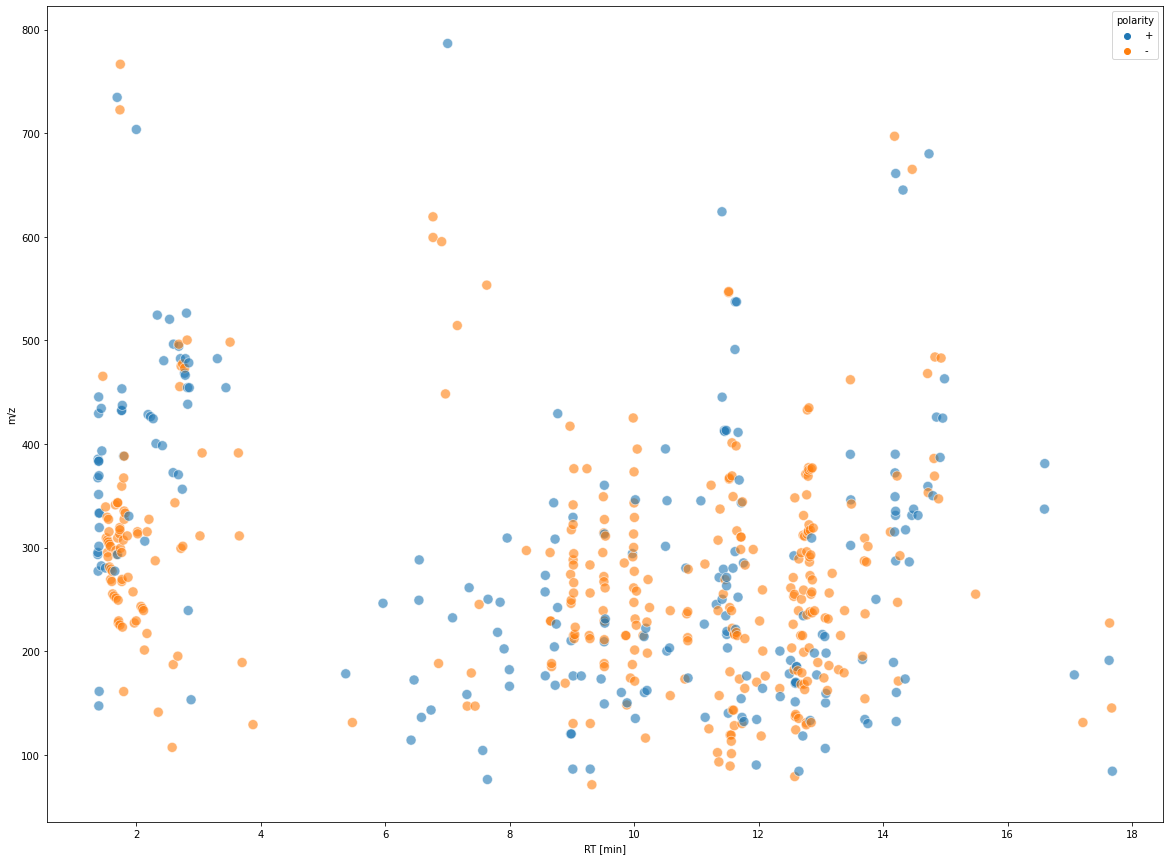

In [477]:
fig, ax = plt.subplots()
# subset = cd.loc[cd['confident_id']]
subset = cd.loc[~cd['confident_id'] & cd['Checked'] \
#                 & (cd['polarity'] == '-')
               ]
sns.scatterplot(
    data=subset,
#     data=cd, style='Checked', markers={True: 'o', False: 'X'},
    y='m/z',
    x='RT [min]',
    hue='polarity',
#     size='is_id', sizes={True: 80, False: 25},
    alpha=0.6,
    s=100,
    ax=ax,
)

# for i, row in subset.iterrows():
#     plt.annotate(row['Name'], (row['RT [min]'], row['m/z']), 
#              horizontalalignment='left', size='medium', color='black', 
#              alpha=0.8,
#             )

fig.set_size_inches(20, 15)
# plt.xlim(0, 5)
# plt.ylim(70, 950)

In [512]:
(subset['cs_ids'].str[0:2].astype('str') + subset['Name'])

967                                                    []
968                                                    []
969     ['beta-D-Ethyl glucuronide', '6-O-Acetyl-D-glu...
971                                                    []
972                                                    []
975                                                    []
976     ['Allamandin', '5,6-Dihydroxy-3-(hydroxymethyl...
977                                                    []
980          ['oxiracetam', 'Methylol Dimethylhydantoin']
981                                              ['3740']
986                                       ['benfuresate']
990     ['his-asp', '9-(beta-D-Ribofuranosyl)-6,9-dihy...
991                                                    []
1001    ['2,3,4,5-Tetrahydroxypentanal', 'D-(−)-Ribose...
1002                                         ['Edoxaban']
1003                                                   []
1004                                                   []
1005    ['3-O-

[]

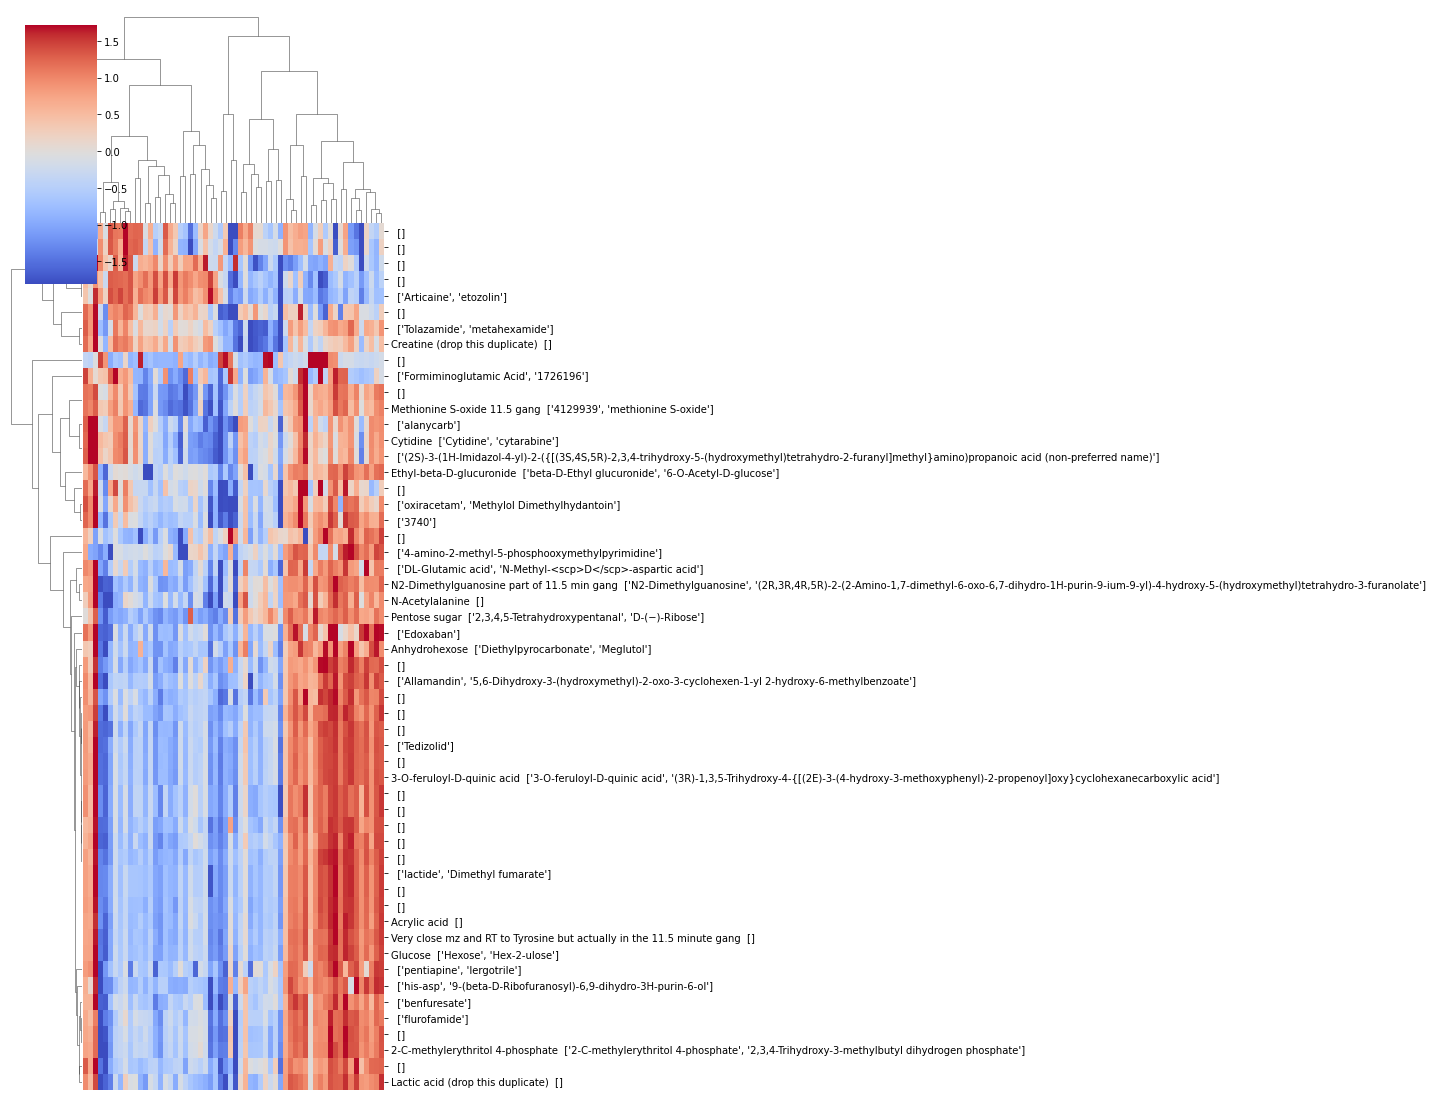

In [514]:
# plt.gcf().set_size_inches(8, 8)
subset = cd.loc[
    (cd['RT [min]'] > 11.2) & (cd['RT [min]'] < 11.9) & \
    (cd['polarity'] == '-')
]

cm = sns.clustermap(
    data=subset[areas], 
#     yticklabels=subset['Name'],
    yticklabels=(subset['Name'] + '  ' + subset['cs_ids'].str[0:2].astype('str')),
    method='complete', metric='correlation',
    z_score=0,
    robust=True,
    cmap='coolwarm',
    figsize=(20, 20),
)
cm.ax_heatmap.set_xticks([])


In [ ]:
sns.heatmap

In [490]:
subset

,Group Area: 20210831_KAO_HILIC_T112M_20210330_8wk_RBG,Group Area: 20210831_KAO_HILIC_T193M20210406_9wk_RBG,Group Area: 20210831_KAO_HILIC_T1060M_20210322_8wk_FBG,Group Area: 20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,Group Area: 20210831_KAO_HILIC_T1060M_20210329_9wk_FBG,Group Area: 20210831_KAO_HILIC_T1060M_20210401_9wk_RBG,Group Area: 20210831_KAO_HILIC_T1060M_20210405_10wk_FBG,Group Area: 20210831_KAO_HILIC_T1060M_20210408_10wk_RBG,Group Area: 20210831_KAO_HILIC_T1062M_20210322_8wk_FBG,Group Area: 20210831_KAO_HILIC_T1062M_20210325_8wk_RBG,...,Group Area: 20210831_KAO_HILIC_T1101M_20210330_8wk_RBG,Group Area: 20210831_KAO_HILIC_T1101M_20210402_9wk_FBG,Group Area: 20210831_KAO_HILIC_T1101M_20210406_9wk_RBG,Group Area: 20210831_KAO_HILIC_T1101M_20210410_10wk_FBG,Group Area: 20210831_KAO_HILIC_T1101M_20210413_10wk_RBG,Group Area: 20210831_KAO_HILIC_T1102M_20210327_8wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210402_9wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210406_9wk_RBG,Group Area: 20210831_KAO_HILIC_T1102M_20210410_10wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210413_10wk_RBG
962,21.558539,21.430289,20.441140,21.387482,21.310430,20.240580,20.940262,21.647591,21.319524,21.465960,...,20.907669,21.184661,21.151096,21.311539,20.356552,21.188251,21.029623,21.316571,20.828006,21.115912
963,19.622072,19.504068,17.890788,19.329967,19.391157,17.247339,18.949431,19.665536,19.228964,19.380759,...,18.722315,19.179952,18.914231,19.332719,17.726160,19.148219,19.083466,19.273218,18.781240,19.016287
964,23.371599,23.332309,22.653452,23.211817,23.207043,23.109947,22.793616,23.454379,23.221875,23.272693,...,22.861677,22.912865,22.936401,23.062541,22.679488,23.067985,22.999372,23.268441,22.768677,23.030469
967,20.240736,20.356333,21.297883,20.300467,20.794605,20.253025,20.585464,19.929030,21.667265,20.593819,...,20.722687,21.141944,20.586703,21.204804,20.127897,21.052057,20.818576,20.096646,21.097089,19.681544
968,20.893727,19.213734,17.819269,20.581210,18.417154,18.552594,18.392875,20.799398,19.320237,20.917727,...,20.416924,18.310740,20.557728,19.026637,20.348945,18.981032,18.571843,20.517835,18.616016,20.001501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,21.882849,20.578647,18.673472,21.497513,20.503224,20.559952,19.694239,22.123090,20.560923,22.343298,...,21.730420,20.677898,21.081930,20.197430,22.055833,19.964821,19.968603,22.100762,19.197942,21.769221
1068,24.546021,24.480182,24.104548,24.647234,24.251209,24.298711,24.134669,24.752169,24.401994,24.704308,...,24.399121,24.077359,24.503637,24.329759,24.315430,24.312843,24.054392,24.626246,24.310216,24.297141
1071,22.500680,22.637285,21.536213,22.445284,21.779522,22.033254,21.630195,22.627981,22.017760,22.645150,...,22.198219,21.614681,22.373800,21.884916,22.013708,21.779586,21.632540,22.509902,21.794252,22.337348
1072,15.596089,15.469054,18.822651,15.621374,15.392664,21.922051,15.330995,15.706640,15.524937,15.682392,...,15.661938,15.500215,15.584707,15.479764,19.897839,15.529735,16.476765,15.645410,16.573074,15.570877


Text(0, 0.5, 'm/z')

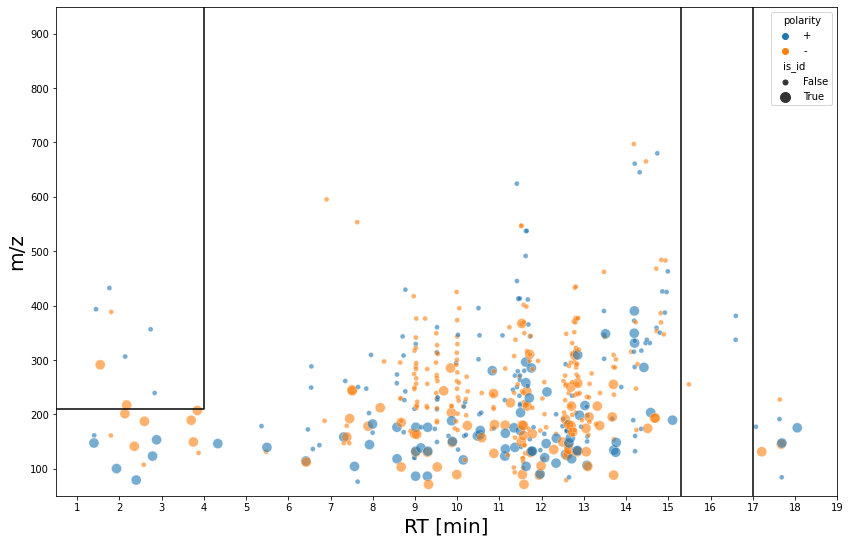

In [470]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=cd.loc[cd['Checked'] & (~cd['is_lipid'])],
#     data=cd, style='Checked', markers={True: 'o', False: 'X'},
    y='m/z',
    x='RT [min]',
    hue='polarity',
    size='is_id', sizes={True: 100, False: 25},
    alpha=0.6,
    s=100,
    ax=ax,
)
fig.set_size_inches(14, 9)
plt.xticks(range(1, 20, 1));
plt.yticks(range(100, 1001, 100))
plt.xlim(0.5, 19)
plt.ylim(50, 950)
plt.axvline(15.3, c='black')
plt.axvline(17, c='black')
plt.plot([0, 4, 4], [210, 210, 1000], c='black')
plt.xlabel('RT [min]', fontsize=20)
plt.ylabel('m/z', fontsize=20)
# plt.plot([0, 4, 4], [210, 210, 375], c='black')
# plt.plot([4, 4], [375, 1000])
# plt.xlim(11, 12.5)

## Features with `m/z > 375` and `RT < 4` are mostly Phospholipids, SMs,  CEs and Carnitines

## Features with `m/z > 210` and `RT < 4` are mostly FAs

In [192]:
rt4 = cd.loc[(cd['m/z'] > 375) & (cd['RT [min]'] < 4)]
rt4.loc[
#     rt4['Checked'] & \
    (rt4['Name'].notna())
]

,Reference Ion,Formula,Checked,Tags,Name,Annot. Source: Predicted Compositions,Annot. Source: mzCloud Search,Annot. Source: Metabolika Search,Annot. Source: ChemSpider Search,Annot. DeltaMass [ppm],...,Group Area: 20210831_KAO_HILIC_T1101M_20210406_9wk_RBG,Group Area: 20210831_KAO_HILIC_T1101M_20210410_10wk_FBG,Group Area: 20210831_KAO_HILIC_T1101M_20210413_10wk_RBG,Group Area: 20210831_KAO_HILIC_T1102M_20210327_8wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210402_9wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210406_9wk_RBG,Group Area: 20210831_KAO_HILIC_T1102M_20210410_10wk_FBG,Group Area: 20210831_KAO_HILIC_T1102M_20210413_10wk_RBG,is_id,polarity
10,[M-H]-1,C30 H37 N5 O2,True,Checked,Tauroursodeoxycholic acid,Not the top hit,Full match,No results,No match,2.04,...,1.742953e+07,4.331789e+07,5.289557e+06,1.101065e+07,5.118802e+07,4.119386e+06,1.997504e+07,1.364370e+07,True,-
14,[M+H]+1,C39 H79 N2 O6 P,False,Checked,SM,Full match,Full match,No results,Full match,-0.19,...,2.130511e+07,8.659862e+06,2.687790e+07,7.696651e+06,1.951742e+07,1.584572e+07,1.174129e+07,1.409551e+07,False,+
24,[M+H]+1,C27 H56 O10,False,Checked,PPG n9,No match,Invalid mass,No results,No results,31508.31,...,1.038769e+06,1.068422e+06,1.257193e+06,1.149797e+06,1.078317e+06,1.407702e+06,1.454212e+06,1.017763e+06,False,+
26,[M-H]-1,C49 H78 N2 O12,True,Checked,PI,Full match,No results,No results,No match,0.72,...,3.499781e+07,3.007065e+07,3.530598e+07,2.697380e+07,4.478356e+07,3.558270e+07,4.111122e+07,3.154287e+07,True,-
29,[M+NH4]+1,C16 H34 O9,False,Checked,PEG n8,Not the top hit,Full match,No results,Full match,-0.24,...,7.505266e+06,8.795956e+06,1.220618e+07,1.193232e+07,9.725890e+06,8.528991e+06,1.650074e+07,3.423837e+06,False,+
32,[M+H]+1,C24 H50 O13,False,Checked,PEG n12,No match,Invalid mass,No results,No results,31165.65,...,8.648593e+05,1.236203e+06,2.097790e+06,2.035234e+06,1.419139e+06,1.254159e+06,2.794094e+06,5.701526e+05,False,+
33,[M+H]+1,C22 H46 O12,False,Checked,PEG n11,No match,Invalid mass,No results,No results,33897.52,...,1.987114e+06,2.480662e+06,3.794660e+06,3.939919e+06,3.018501e+06,2.281813e+06,5.213318e+06,1.118061e+06,False,+
34,[M+H]+1,C26 H54 N O7 P,False,Checked,PC Platelet-activating factor,Full match,No results,No results,Full match,0.26,...,5.213628e+08,3.833081e+08,4.543154e+08,4.680174e+08,5.364133e+08,5.745449e+08,4.534873e+08,5.167224e+08,False,+
35,[M+H]+1,C42 H80 N O8 P,False,Checked,PC,No results,No results,No results,Full match,0.12,...,2.723843e+08,1.515456e+08,3.413968e+08,1.623434e+08,2.089015e+08,3.156708e+08,2.230134e+08,2.559351e+08,False,+
36,[M+H]+1,C44 H84 N O8 P,False,Checked,PC,Full match,No results,No results,Full match,-0.22,...,2.691330e+08,7.458653e+07,2.800207e+08,1.005319e+08,1.368559e+08,3.252766e+08,1.571927e+08,2.633671e+08,False,+


## Most features between `15.3 < RT < 17` have a distinct polymer-like pattern and no IDs among them 

- pattern also correlates well between negative and positive  mode

### Looking at the correlation of all the features between 15 and 17, they correlate among themselves very highly, suggesting they're a persistent polymer

(0.8235481618698131, 1.0084024684823898)

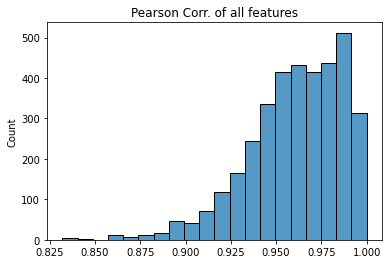

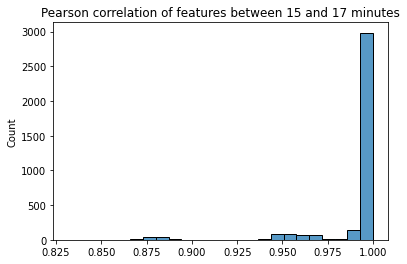

In [75]:
# Compare to null distribution which is all of them together
plt.figure()
plt.title('Pearson Corr. of all features')
sns.histplot(cd[areas].corr().values.reshape(-1), bins=20)
null_xlim = plt.xlim()

plt.figure()
feats_15_17 = cd.loc[(cd['RT [min]'] < 17) & (cd['RT [min]'] > 15) & \
       (cd['Checked']) \
#      & (cd['Name'].notna())
      ]
sns.histplot(feats_15_17[areas].corr().values.reshape(-1), bins=20)
plt.title('Pearson correlation of features between 15 and 17 minutes')
plt.xlim(null_xlim)

In [169]:
rt1517 = cd.loc[(cd['RT [min]'] > 15.3) & (cd['RT [min]'] < 17)]
print(rt1517['Annot. Source: mzCloud Search'].unique())
print(rt1517['Annot. Source: ChemSpider Search'].unique())

['No results' 'Invalid mass']
['No results' 'No match']


## Filtering out the features 

In [232]:
~(cd['Name'].str.contains('Likely', na=False))

0      True
1      True
2      True
3      True
4      True
       ... 
944    True
945    True
946    True
947    True
948    True
Name: Name, Length: 949, dtype: bool

In [253]:
cdf = cd.loc[
    ~((cd['RT [min]'] < 4) & (cd['m/z'] > 210)) & \
    ~((cd['RT [min]'] > 15.3) & (cd['RT [min]'] < 17)) & \
    ~(cd['Name'].str.contains('Likely', na=False)) & ~(cd['Name'].str.contains('\?', na=False)) & \
    (cd['Checked'] == True)
]
cdf['Name'].value_counts()[:]

Leucine/Isoleucine                                   4
Guanidinosuccinic acid check close eluting isomer    2
Proline                                              2
Hydroxyproline                                       2
Serine                                               2
                                                    ..
Hydroxyvaleric acid                                  1
Hydroxycinnamic acid                                 1
Hydroxybutyric acid                                  1
Homoserine lactone                                   1
2-Amino-4-methylpyrimidine                           1
Name: Name, Length: 64, dtype: int64

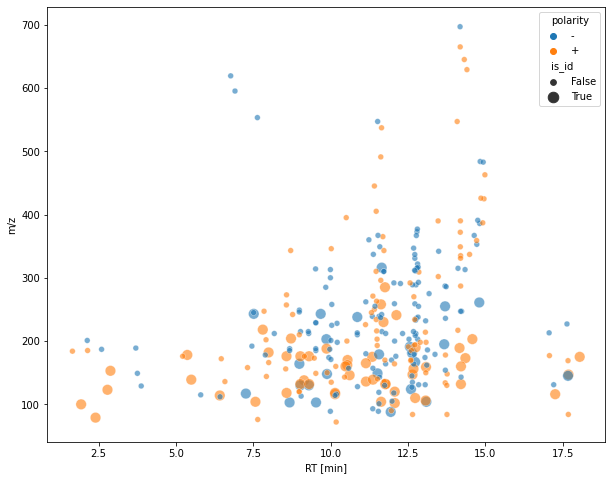

In [218]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=cdf,
#     data=cd, style='Checked', markers={True: 'o', False: 'X'},
    y='m/z',
    x='RT [min]',
    hue='polarity', 
    size='is_id', sizes={True: 111, False: 33},
    alpha=0.6,
    s=100,
    ax=ax,
)
fig.set_size_inches(10, 8)

(70.0, 360.0)

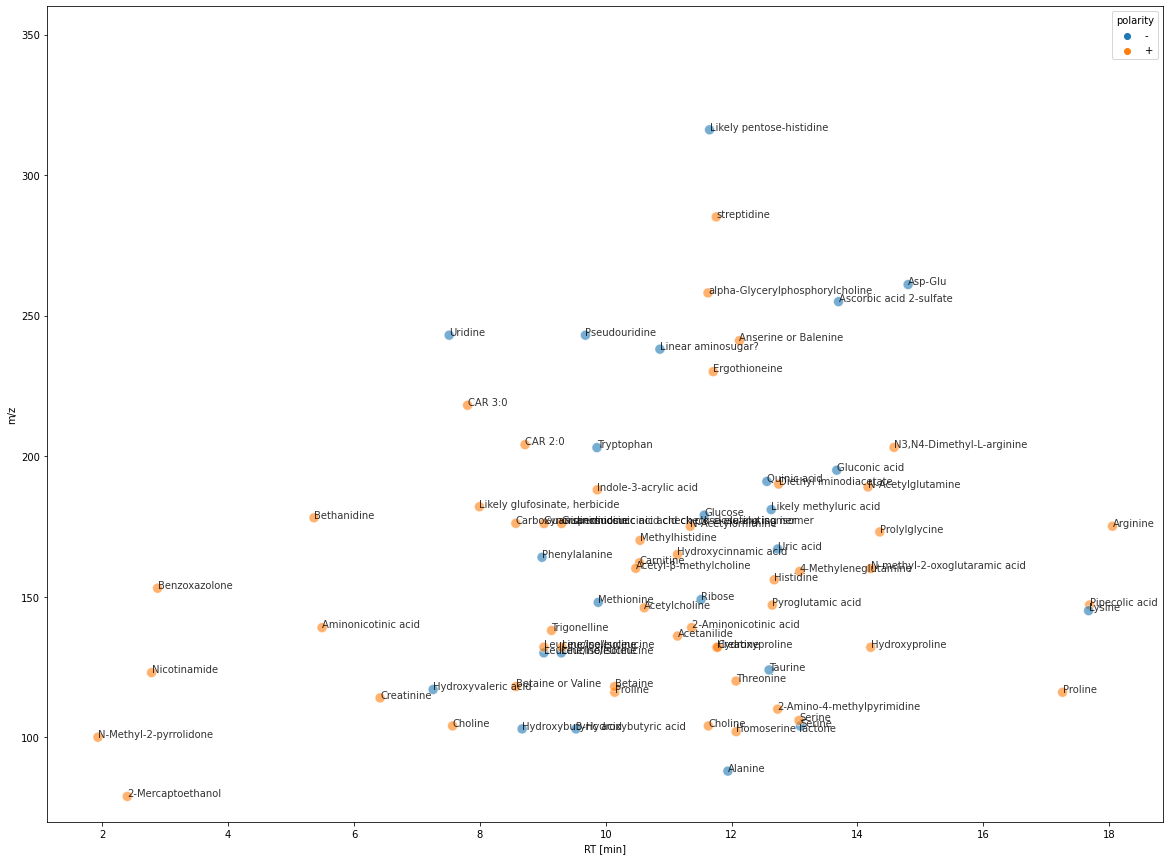

In [224]:
fig, ax = plt.subplots()

sns.scatterplot(
    data=cdf.loc[cdf['is_id']],
#     data=cd, style='Checked', markers={True: 'o', False: 'X'},
    y='m/z',
    x='RT [min]',
    hue='polarity',
#     size='is_id', sizes={True: 80, False: 25},
    alpha=0.6,
    s=100,
    ax=ax,
)

for i, row in cdf.loc[cdf['is_id']].iterrows():
    plt.annotate(row['Name'], (row['RT [min]'], row['m/z']), 
             horizontalalignment='left', size='medium', color='black', 
             alpha=0.8,
            )

fig.set_size_inches(20, 15)
# plt.xlim(0, 5)
plt.ylim(70, 360)

In [114]:
mz = {}
cs = {}

with open(mzcloud_path) as mzf:
    with open(chemspider_path) as csf:
        mzr = csv.reader(mzf)
        csr = csv.reader(csf)
        header = next(mzr)
        next(mzr)
        mzheader = next(mzr)
        mz_id_name_index = mzheader.index('Name')
        next(csr)
        next(csr)
        csheader = next(csr)
        cs_id_name_index = csheader.index('Name')
        mzf.seek(1)
        csf.seek(1)     
        i = 0
        for line in mzr:
            if '[' in line[0]:  # Compound data
                compound_line = line
                next(mzr)  # skip the mzCloud subheader
                line = next(mzr)
                if '[' in line[0]:
                    continue
                names = []
                while line[1] == '':
                    names.append(line[mz_id_name_index])
                    line = next(mzr)
                data = {key: value for key, value in zip(header, compound_line)}
                data['id_names'] = names
                mz[i] = data
                i += 1
            if i == 5:
                break

In [24]:
mz_lines = [line for line in csv.reader(open(mzcloud_path))]
header = mz_lines[0]
subheader = mz_lines[2]
mz_id_name_index = subheader.index('Name')
# things

mz = {}
index = 0
for i, line in enumerate(mz_lines[1:], start=1):
    if '[' in line[0]:
        data = {key: value for key, value in zip(header, line)}
        next_line_index = i + 2
        next_line = mz_lines[next_line_index]
        names = []
        print(next_line)
        while next_line[1] == '':
            print('while')
            names.append(next_line[mz_id_name_index])
            next_line_index += 1
            next_line = mz_lines[next_line_index]
        data['id_names'] = names
        mz[index] = data 
        index += 1
#     if index == 50:
#         break

['[M-H]-1', 'C24 H51 N2 O9 P', 'TRUE', 'Checked', '', 'Full match', 'No results', 'No results', 'No results', '-2.15', '542.33205', '541.32476', '2.616', '6538473.069', '0', '', '', 'DDA for preferred ion', '', '', '', '0', '0.18', '', '0', '0', '0', '0.03', '', '0.04', '', '', '0', '0', '0', '0', '0', '0', '', '0', '0', '', '0', '0', '0.07', '0', '0', '0', '', '', '0', '', '0', '0.01', '0', '0', '0', '', '0', '', '0', '0', '0', '', '0', '0.09', '0.12', '0', '', '0', '0', '0.08', '0', '0.18', '', '', '0.02', '0', '0', '', '0', '0', '0', '0', '', '0.2', '', '', '', '4.2', '2.1', '1', '7.5', '3.7', '3.7', '2.1', '1', '3.7', '1', '1', '4.8', '4.8', '3.7', '8', '6.4', '7', '1', '6.4', '4.2', '1', '7.5', '3.7', '1', '3.7', '7.5', '4.2', '1', '1', '7', '1', '8.6', '2.6', '4.2', '3.2', '7.5', '1', '7.2', '1', '4.8', '7.5', '8', '1', '7.5', '3.2', '2.6', '7', '1', '4.2', '7', '2.1', '7.5', '2.6', '1', '1', '2.6', '8', '3.7', '1', '3.7', '7.5', '7', '7.5', '1', '1.5', '', '', '', '0.01', '0.03'

IndexError: list index out of range